In [ ]:
!pip install lasio pandas numpy matplotlib seaborn



In [ ]:
import lasio
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer

# MR3D phase 4: the synthetic resistivity well log dataset
Phase:1 This dataset only contains only two log curves:

*   DEPT (Depth in meters)
*   RESD (Resistivity-Deep)

We are using the MR3D Synthetic Resistivity Well Log Dataset because it provides high-resolution, pre-processed resistivity data from 27 wells. Since the dataset is already cleaned and structured, we can directly apply our models.  

Your dataset consists of depth (DEPT) and resistivity (RESD) values from multiple well logs. Resistivity measures how strongly a formation resists the flow of electric current—a key parameter in geophysical logging.

* Low resistivity → Indicates water-filled formations.
* High resistivity → Suggests hydrocarbons (oil & gas) or tight formations.
* Extremely high resistivity → Could be due to deep resistive formations, data noise, or tool malfunction.

This dataset serves as an excellent prototyping tool for AI-driven resistivity analysis because it allows us to test and refine machine learning models in a controlled, noise-free environment before applying them to real-world well logs, which often contain missing values, noise, and inconsistencies.

In [ ]:
data_folder = "/content/drive/MyDrive/Projects/Halliburton/Dataset 1/Data Sheet 2"

las_files = [f for f in os.listdir(data_folder) if f.endswith('.las')]

sample_file = os.path.join(data_folder, las_files[0])
las = lasio.read(sample_file)

print(f"Loaded LAS file: {las.well.WELL.value}")
print(f"Available log curves: {las.curves.keys()}")
print(las.df().head())
print(len(las.df()))

Loaded LAS file: 1-RJS-219A
Available log curves: ['DEPT', 'RESD']
             RESD
DEPT             
1298.3002  1.1907
1298.4525  1.1170
1298.6050  1.0630
1298.7573  1.0846
1298.9098  1.1415
15213


In [ ]:

all_wells_data = []

for file in las_files:
    las_path = os.path.join(data_folder, file)
    las = lasio.read(las_path)

    df = las.df().reset_index()
    df["Well"] = file.replace("_logs.las", "")

    all_wells_data.append(df)

df = pd.concat(all_wells_data, ignore_index=True)

print(df.head())

df.to_csv("mr3d_resistivity_logs.csv", index=False)


        DEPT    RESD        Well
0  1298.3002  1.1907  1-RJS-219A
1  1298.4525  1.1170  1-RJS-219A
2  1298.6050  1.0630  1-RJS-219A
3  1298.7573  1.0846  1-RJS-219A
4  1298.9098  1.1415  1-RJS-219A


In [ ]:
print(len(df))
n_wells = df['Well'].nunique()
print(f'Number of wells =  {n_wells}')

329340
Number of wells =  26


In [ ]:
df.head()

,DEPT,RESD,Well
0,1298.3002,1.1907,1-RJS-219A
1,1298.4525,1.1170,1-RJS-219A
2,1298.6050,1.0630,1-RJS-219A
3,1298.7573,1.0846,1-RJS-219A
4,1298.9098,1.1415,1-RJS-219A


### Data Analysis, Cleaning and Pre-processing

In [ ]:
RESD_count = df['RESD'].isna().sum()
DEPT_count = df['DEPT'].isna().sum()

print(f'Number of Nan values in RESD" = {RESD_count}')
print(f'Number of Nan values in RESD" = {DEPT_count}')

Number of Nan values in RESD" = 17
Number of Nan values in RESD" = 0


In [ ]:
# Since the number of missing values is negligible, it’s best to drop them instead of imputing.
print(f'Length before removing null values" = {len(df)}')
df.dropna(subset=["RESD"], inplace=True)
print(f'Length after removing null values" = {len(df)}')

Length before removing null values" = 329340
Length after removing null values" = 329323


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Basic Statistics
summary_stats = df["RESD"].describe()
print(summary_stats)

count    329323.000000
mean         34.442149
std         641.169995
min           0.048000
25%           1.241300
50%           1.409700
75%           1.716700
max       91406.367200
Name: RESD, dtype: float64


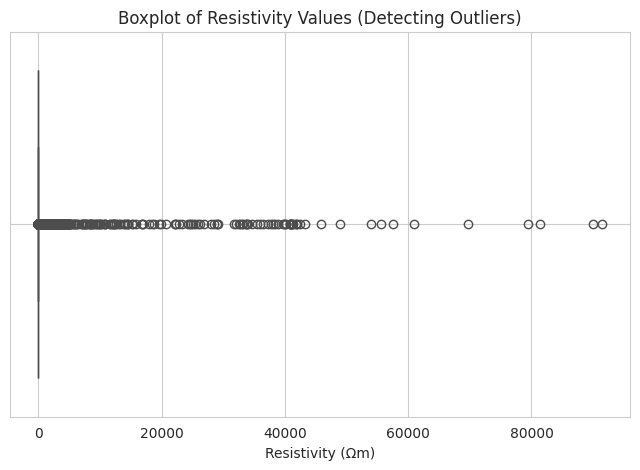

In [ ]:
#Boxplot of Resistivity
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["RESD"], color="blue")
plt.xlabel("Resistivity (Ωm)")
plt.title("Boxplot of Resistivity Values (Detecting Outliers)")
plt.grid(True)
plt.show()


In [ ]:
df[df["RESD"] == 0].describe()  # Check depth distribution of zero resistivity values


,DEPT,RESD
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


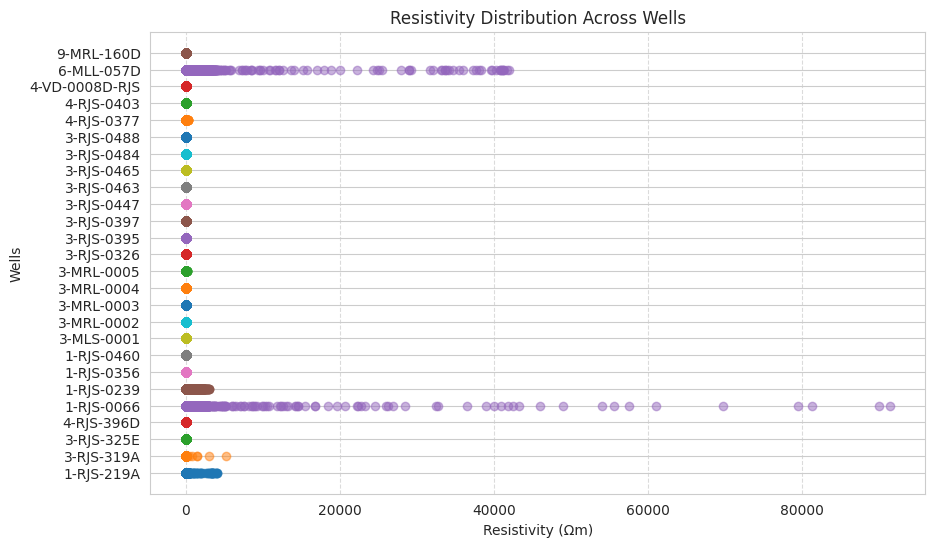

In [ ]:
plt.figure(figsize=(10, 6))

for well in df["Well"].unique():
    subset = df[df["Well"] == well]
    plt.scatter(subset["RESD"], [well] * len(subset), label=well, alpha=0.5)

plt.xlabel("Resistivity (Ωm)")
plt.ylabel("Wells")
plt.title("Resistivity Distribution Across Wells")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

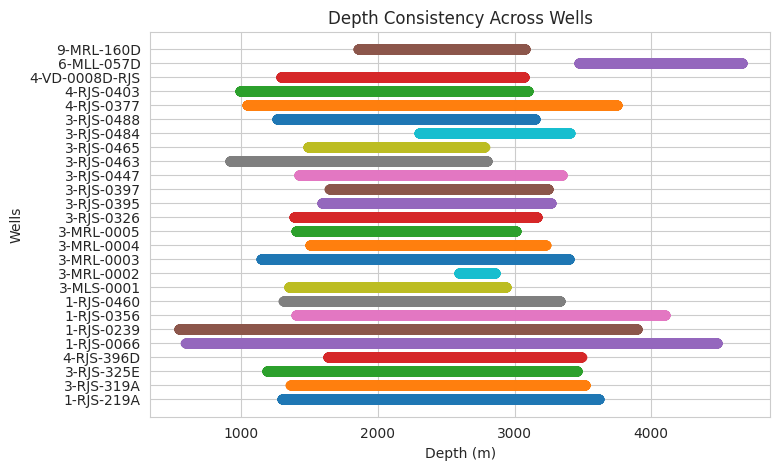

In [ ]:
plt.figure(figsize=(8, 5))
for well in df["Well"].unique():
    subset = df[df["Well"] == well]
    plt.scatter(subset["DEPT"], [well] * len(subset), label=well, alpha=0.5)

plt.xlabel("Depth (m)")
plt.ylabel("Wells")
plt.title("Depth Consistency Across Wells")
plt.show()


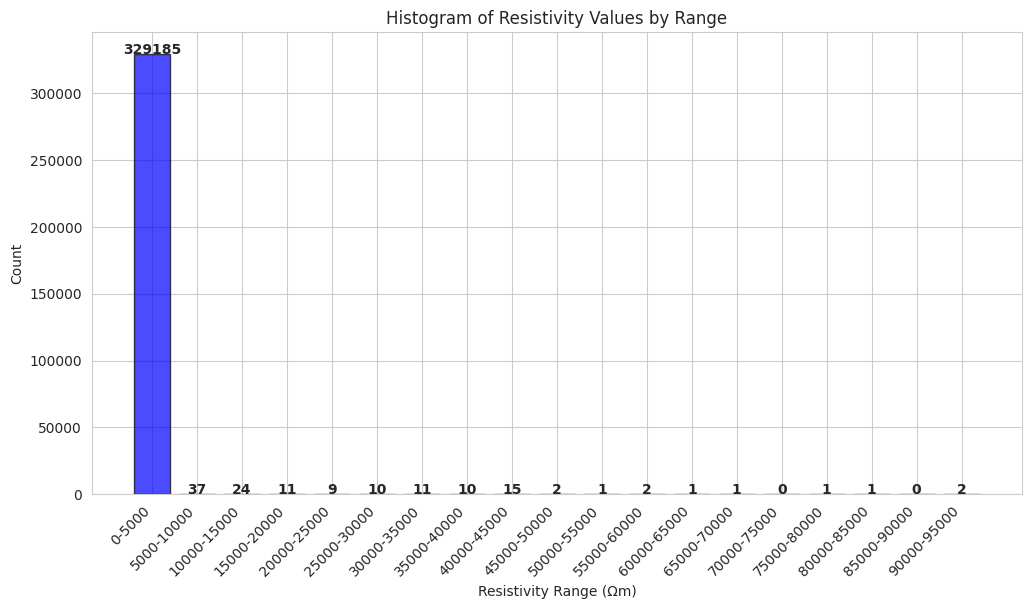

In [ ]:
bins = np.arange(0, df["RESD"].max() + 5000, 5000)
hist_counts, bin_edges = np.histogram(df["RESD"], bins=bins)

bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]

plt.figure(figsize=(12, 6))
plt.bar(bin_labels, hist_counts, color='blue', alpha=0.7, edgecolor='black')
plt.xticks(rotation=45, ha="right")
plt.xlabel("Resistivity Range (Ωm)")
plt.ylabel("Count")
plt.title("Histogram of Resistivity Values by Range")

for i, count in enumerate(hist_counts):
    plt.text(i, count + 100, str(count), ha='center', fontsize=10, fontweight='bold')

plt.show()


In [ ]:
df[df["RESD"] > 50000].describe()  # Check depth distribution of zero resistivity values

,DEPT,RESD
count,9.000000,9.000000
mean,4126.757489,71119.089844
std,0.580321,14856.329253
min,4126.046400,53969.941400
25%,4126.351100,57586.585900
50%,4126.655800,69721.085900
75%,4126.960900,81301.804700
max,4127.722700,91406.367200


Since there are only 9 values greater than 50,000 Ωm

we need to verify if they Are Real or Noise

To check if these extreme values are valid geological readings or potential errors:

1) Check Their Depths
If they are concentrated at specific depths, they may indicate a real formation type.
If they are scattered randomly, they might be instrumental noise.

In [ ]:
df_fil = df[df["RESD"] > 10000][["DEPT", "RESD","Well"]]
wells_gt_10000 = df_fil['Well'].unique()
print("Wells having resistance greater than 50000 = ", wells_gt_10000)
df_fil

Wells having resistance greater than 50000 =  ['1-RJS-0066' '6-MLL-057D']


,DEPT,RESD,Well
79648,4121.7793,10037.0498,1-RJS-0066
79649,4121.9316,15440.3535,1-RJS-0066
79650,4122.0840,20725.6465,1-RJS-0066
79651,4122.2363,22817.0039,1-RJS-0066
79652,4122.3887,22184.6445,1-RJS-0066
...,...,...,...
320204,4494.2803,29184.1270,6-MLL-057D
320205,4494.4326,24834.4727,6-MLL-057D
320206,4494.5850,27998.4414,6-MLL-057D
320298,4508.6060,15173.3174,6-MLL-057D


The following plot clearly shows a massive jump in resistivity change around 4000m depth in Well 1-RJS-0066. This suggests that something unusual is happening at this depth.

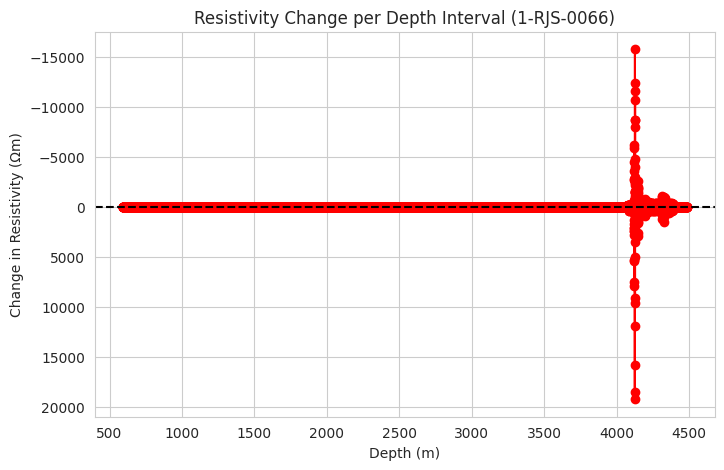

In [ ]:
df_sorted = df[df["Well"] == "1-RJS-0066"].sort_values("DEPT")
df_sorted["RESD_diff"] = df_sorted["RESD"].diff()

plt.figure(figsize=(8, 5))
plt.plot(df_sorted["DEPT"], df_sorted["RESD_diff"], marker="o", linestyle="-", color="red")
plt.gca().invert_yaxis()  # Depth increases downward
plt.xlabel("Depth (m)")
plt.ylabel("Change in Resistivity (Ωm)")
plt.title("Resistivity Change per Depth Interval (1-RJS-0066)")
plt.axhline(y=0, color="black", linestyle="--")
plt.show()


### How to Check if the High Resistivity Values Are Noise or Geologically Valid?

 * The dataset consists of resistivity measurements from 27 wells within the Marlim oilfield, meaning that all wells are expected to have broadly similar geological formations and fluid distributions.
 * Resistivity values in wells 1-RJS-0066 and 6-MLL-057D are greater than 5,000 Ωm within the 4000–4500m depth range.
 * According to the web, high resistivity generally indicates hydrocarbons (oil or gas), while lower resistivity is often associated with water-filled formations.
 * If these wells were in a hydrocarbon-rich zone, we would expect other nearby wells at the same depth to also reflect this pattern.
 * Other wells at this depth should show lower resistivity, to prove that 1-RJS-0066's and 6-MLL-057D's measurement is either erroneous or caused by an isolated geological factor.
 * Sometimes, well logs have spikes due to sensor issues, tool miscalibration, or transmission errors.
 * Since there is not enough overlapping data across wells at depths above 4000m, we should focus only on depth intervals that have consistent well coverage.
 * We will filter the dataset to analyze only the overlapping depth ranges across multiple wells to ensure a reliable interpretation.






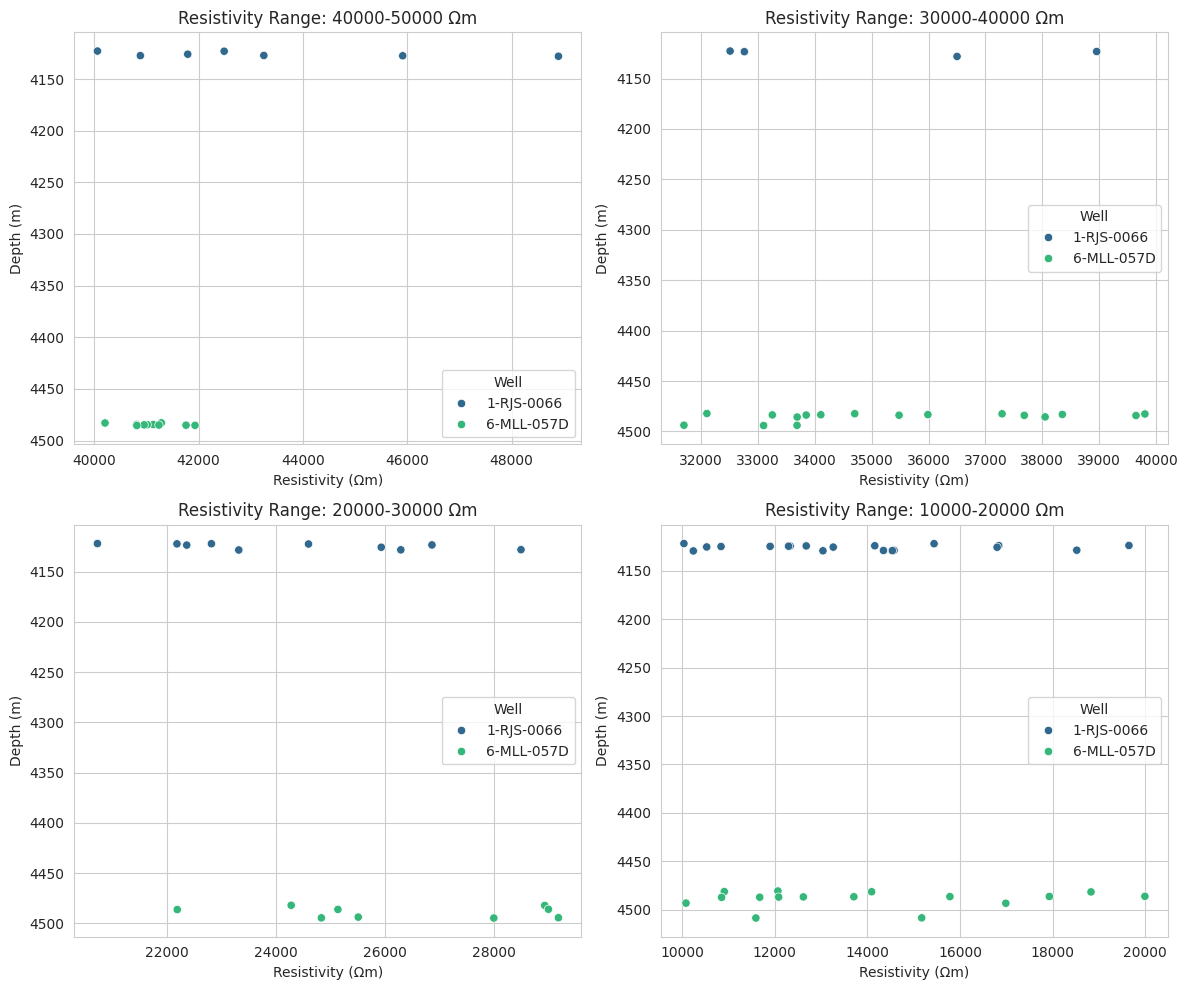

In [ ]:
ranges = [(40000, 50000), (30000, 40000), (20000, 30000), (10000, 20000)]
titles = ["40000-50000 Ωm", "30000-40000 Ωm", "20000-30000 Ωm", "10000-20000 Ωm"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, (r_min, r_max) in enumerate(ranges):
    ax = axes[i // 2, i % 2]
    df_filtered = df[(df["RESD"] >= r_min) & (df["RESD"] < r_max)]

    sns.scatterplot(data=df_filtered, x="RESD", y="DEPT", hue="Well", palette="viridis", ax=ax)

    ax.invert_yaxis()
    ax.set_xlabel("Resistivity (Ωm)")
    ax.set_ylabel("Depth (m)")
    ax.set_title(f"Resistivity Range: {titles[i]}")

plt.tight_layout()
plt.show()


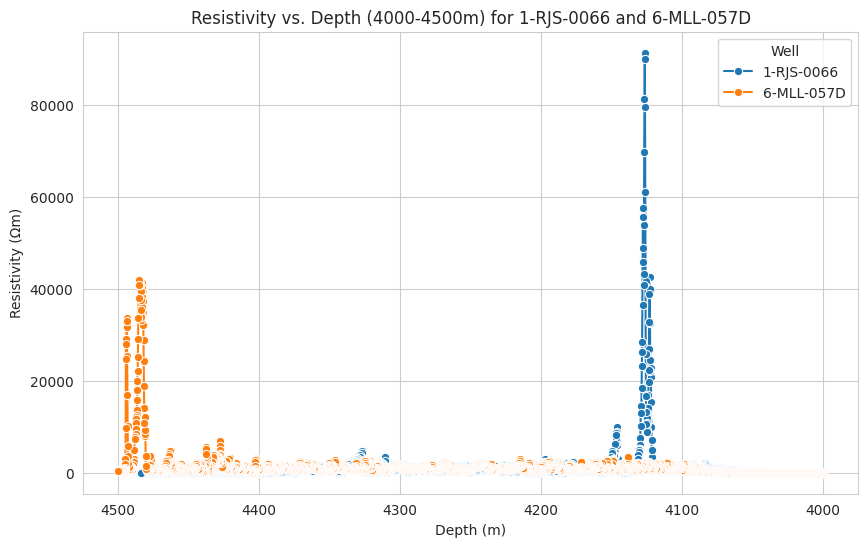

In [ ]:
df_filtered = df[(df["Well"].isin(["1-RJS-0066", "6-MLL-057D"])) &
                 (df["DEPT"] >= 4000) & (df["DEPT"] <= 4500)]

df_filtered = df_filtered.sort_values(["Well", "DEPT"])
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_filtered, x="DEPT", y="RESD", hue="Well", marker="o")

plt.gca().invert_xaxis()
plt.xlabel("Depth (m)")
plt.ylabel("Resistivity (Ωm)")
plt.title("Resistivity vs. Depth (4000-4500m) for 1-RJS-0066 and 6-MLL-057D")
plt.legend(title="Well")
plt.grid(True)
plt.show()


In [ ]:
len(df[df["RESD"] > 15000][["DEPT", "RESD","Well"]])

77

### Refining the Dataset for Consistent Depth Analysis
As observed in the Depth Consistency Across Wells plot, the depth range above 4000m exhibits inconsistency across different wells, with some wells missing data in this range entirely. Additionally, we identified potential noise and anomalies in resistivity values for wells 1-RJS-0066 and 6-MLL-057D in the 4000–4500m depth range, which do not align with trends observed in other wells.

To ensure a robust and consistent analysis, we will restrict our dataset to depths below 4000m, where we have more uniform coverage across wells and fewer data integrity concerns.



In [ ]:
df = df[df["DEPT"] < 4000].copy()

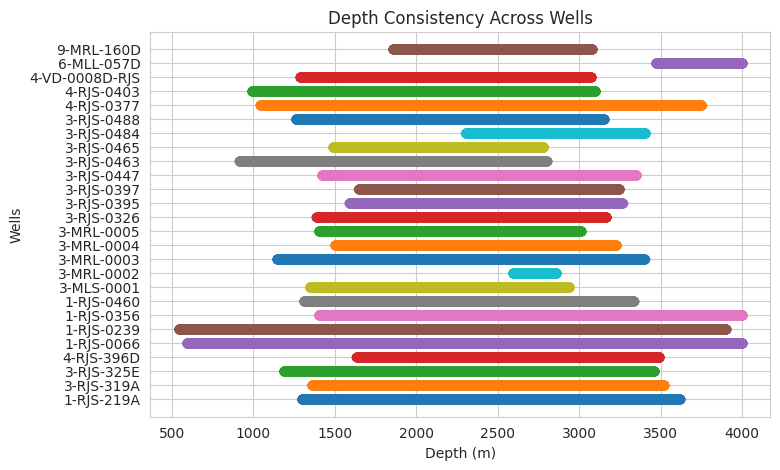

In [ ]:
plt.figure(figsize=(8, 5))
for well in df["Well"].unique():
    subset = df[df["Well"] == well]
    plt.scatter(subset["DEPT"], [well] * len(subset), label=well, alpha=0.5)

plt.xlabel("Depth (m)")
plt.ylabel("Wells")
plt.title("Depth Consistency Across Wells")
plt.show()

Let us check the resistivity distribution across all wells

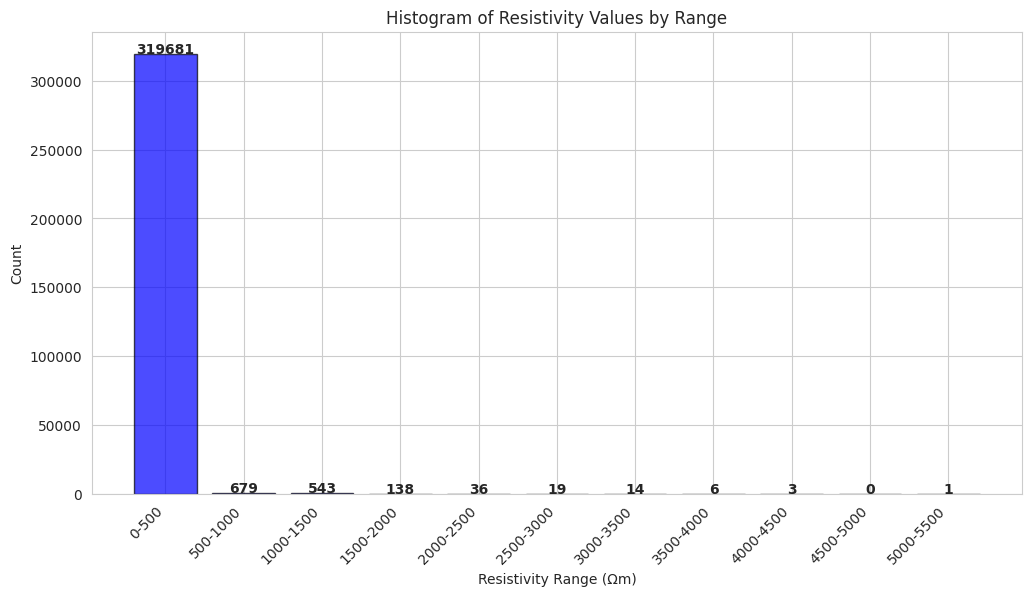

In [ ]:
bins = np.arange(0, df["RESD"].max() + 500, 500)
hist_counts, bin_edges = np.histogram(df["RESD"], bins=bins)

bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]

plt.figure(figsize=(12, 6))
plt.bar(bin_labels, hist_counts, color='blue', alpha=0.7, edgecolor='black')
plt.xticks(rotation=45, ha="right")
plt.xlabel("Resistivity Range (Ωm)")
plt.ylabel("Count")
plt.title("Histogram of Resistivity Values by Range")

for i, count in enumerate(hist_counts):
    plt.text(i, count + 100, str(count), ha='center', fontsize=10, fontweight='bold')

plt.show()

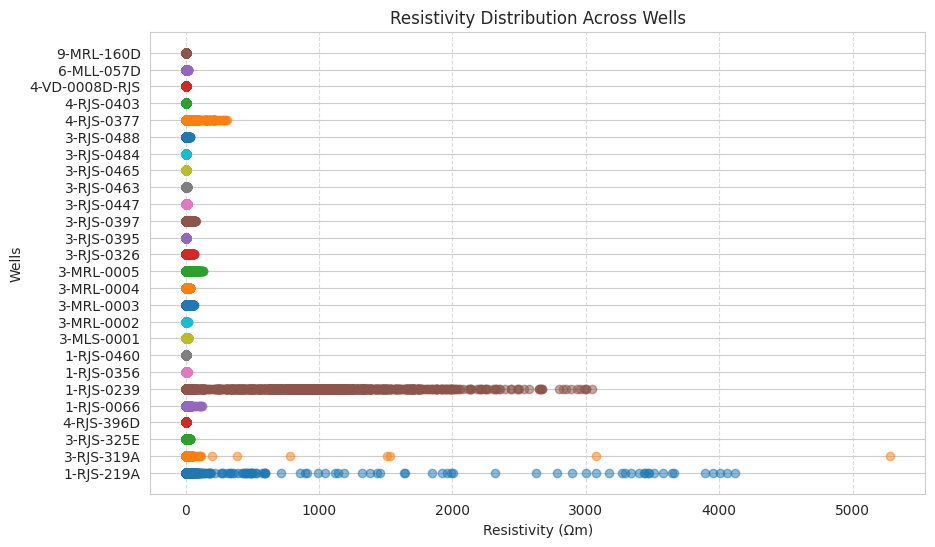

In [ ]:
plt.figure(figsize=(10, 6))

for well in df["Well"].unique():
    subset = df[df["Well"] == well]
    plt.scatter(subset["RESD"], [well] * len(subset), label=well, alpha=0.5)

plt.xlabel("Resistivity (Ωm)")
plt.ylabel("Wells")
plt.title("Resistivity Distribution Across Wells")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


In [ ]:
unique_wells = df[df["RESD"] > 500]["Well"].unique()
unique_wells

array(['1-RJS-219A', '3-RJS-319A', '1-RJS-0239'], dtype=object)

It looks like well 1-RJS-0239 and 1-RJS-0219A has significantly higher resistivity values compared to others, which could indicate anomalous readings or unique geological formations in that well.

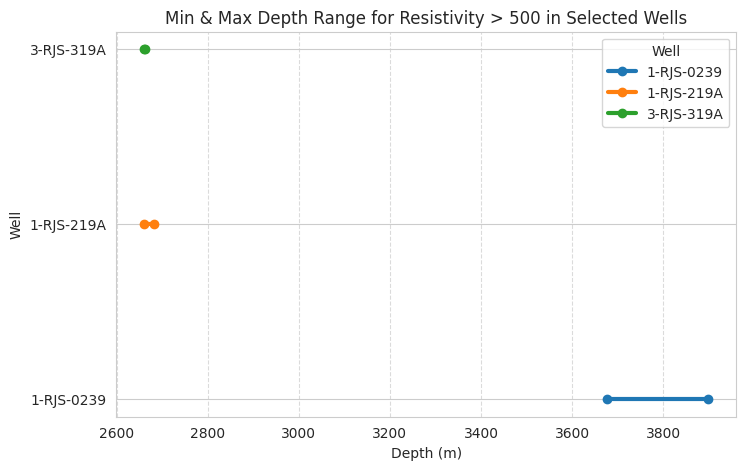

In [ ]:
df_high_resistivity = df[(df["RESD"] > 500) & (df["Well"].isin(unique_wells))]

# Min and max depth per well
well_depth_ranges = df_high_resistivity.groupby("Well")["DEPT"].agg(["min", "max"]).reset_index()

plt.figure(figsize=(8, 5))
for index, row in well_depth_ranges.iterrows():
    plt.plot([row["min"], row["max"]], [row["Well"], row["Well"]], marker="o", linewidth=3, label=row["Well"])

plt.xlabel("Depth (m)")
plt.ylabel("Well")
plt.title("Min & Max Depth Range for Resistivity > 500 in Selected Wells")
plt.legend(title="Well")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

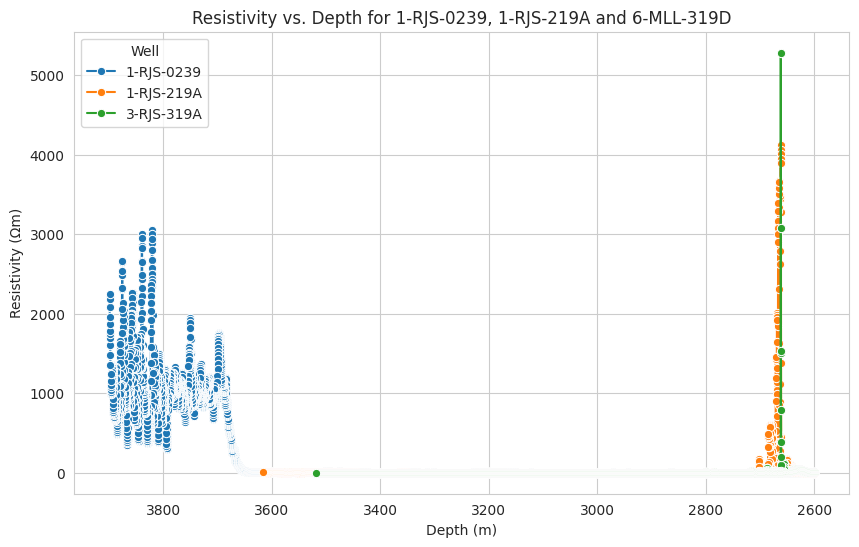

In [ ]:
df_filtered = df[(df["Well"].isin(unique_wells)) &
                 (df["DEPT"] >= 2600) & (df["DEPT"] <= 4000)]

df_filtered = df_filtered.sort_values(["Well", "DEPT"])
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_filtered, x="DEPT", y="RESD", hue="Well", marker="o")

plt.gca().invert_xaxis()
plt.xlabel("Depth (m)")
plt.ylabel("Resistivity (Ωm)")
plt.title("Resistivity vs. Depth for 1-RJS-0239, 1-RJS-219A and 6-MLL-319D")
plt.legend(title="Well")
plt.grid(True)
plt.show()


Let's check the resistivity of other wells at this depth

<ipython-input-28-e10d7c1de87b>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="RESD", y="Well", data=df_well_res, palette="viridis")


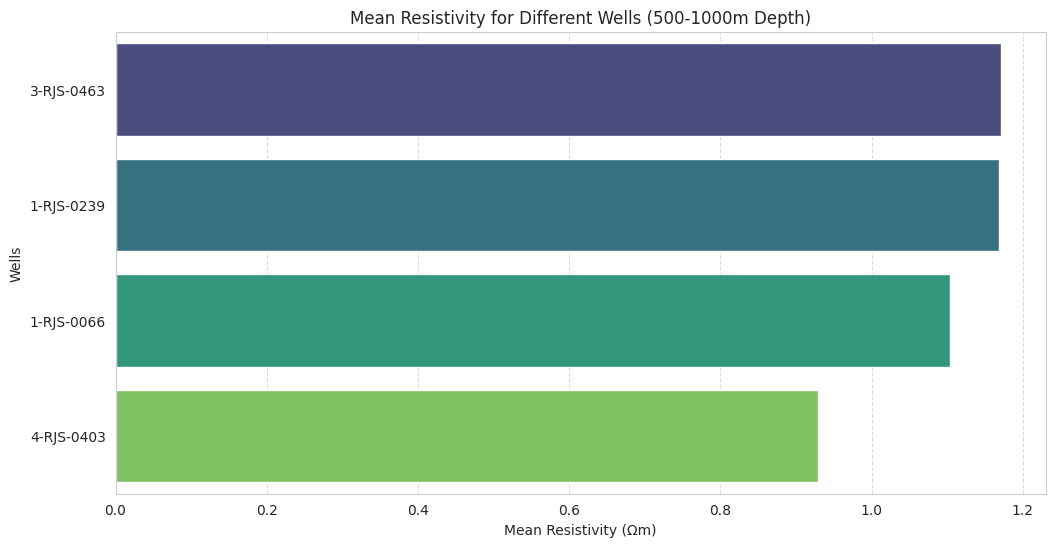

<ipython-input-28-e10d7c1de87b>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="RESD", y="Well", data=df_well_res, palette="viridis")


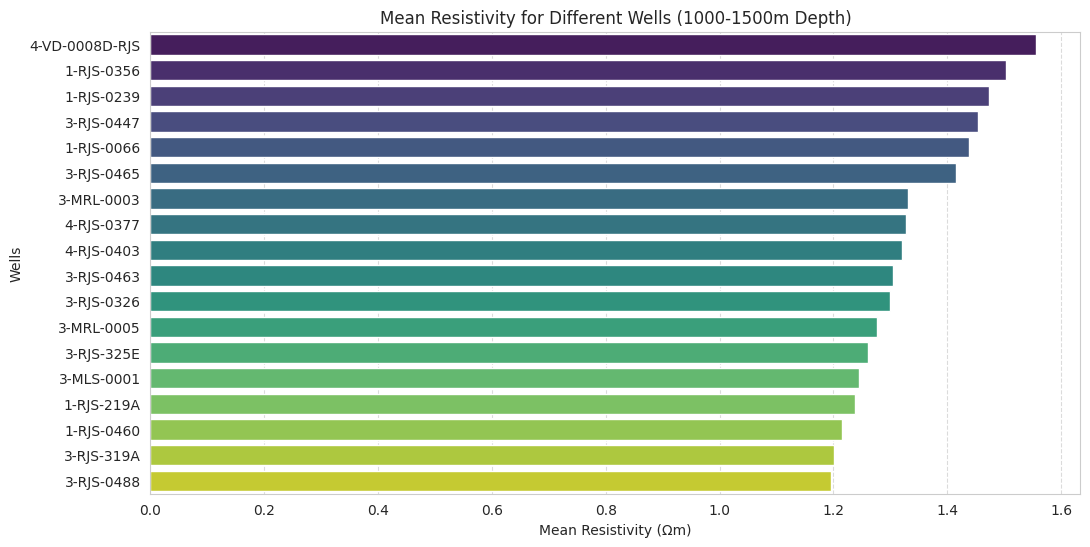

<ipython-input-28-e10d7c1de87b>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="RESD", y="Well", data=df_well_res, palette="viridis")


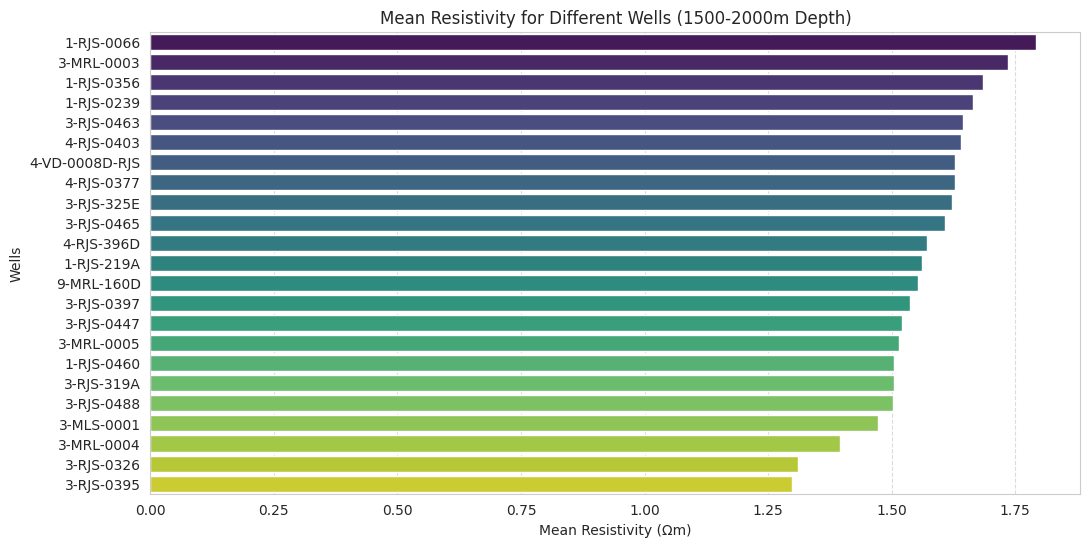

<ipython-input-28-e10d7c1de87b>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="RESD", y="Well", data=df_well_res, palette="viridis")


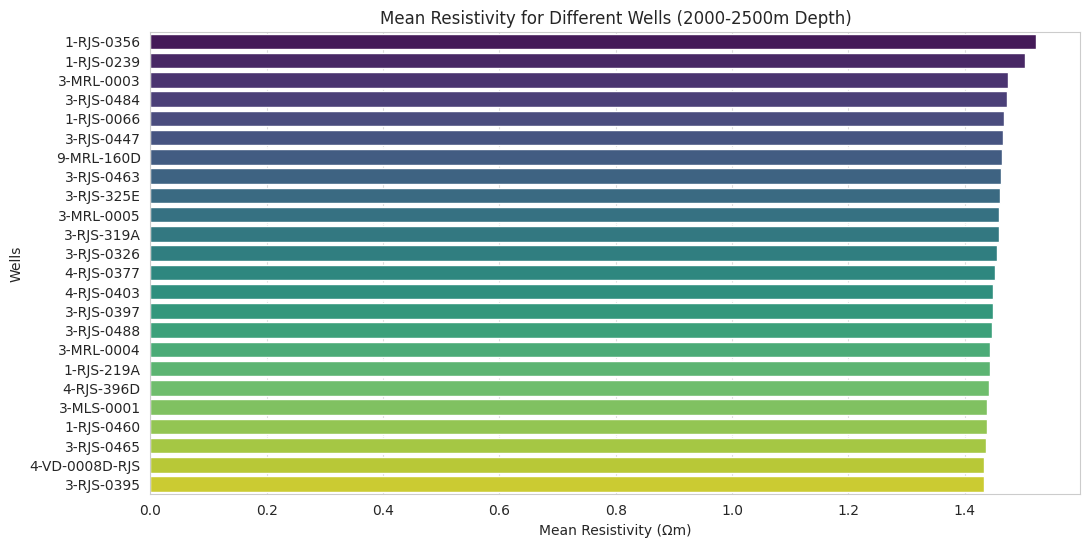

<ipython-input-28-e10d7c1de87b>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="RESD", y="Well", data=df_well_res, palette="viridis")


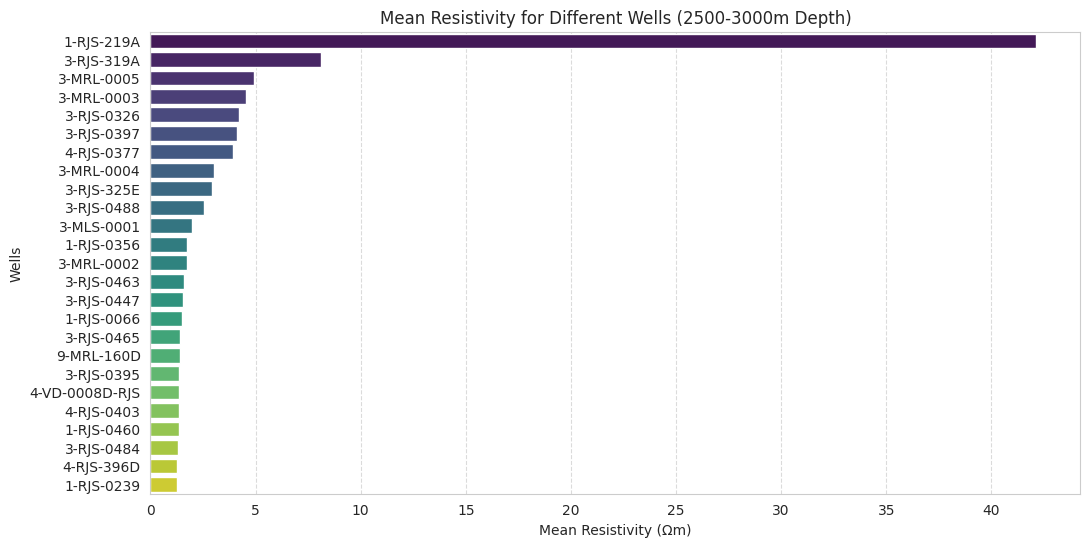

<ipython-input-28-e10d7c1de87b>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="RESD", y="Well", data=df_well_res, palette="viridis")


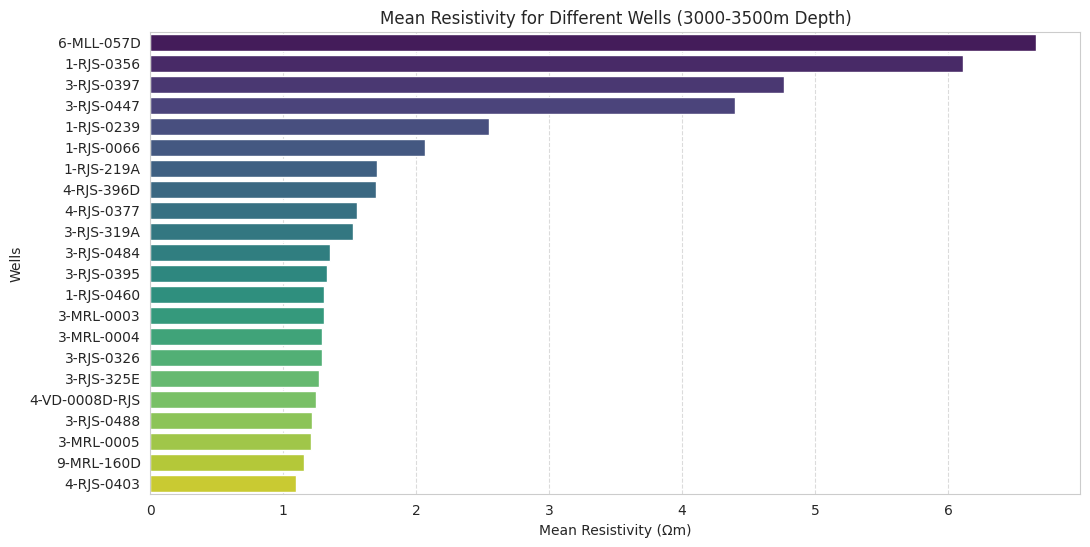

<ipython-input-28-e10d7c1de87b>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="RESD", y="Well", data=df_well_res, palette="viridis")


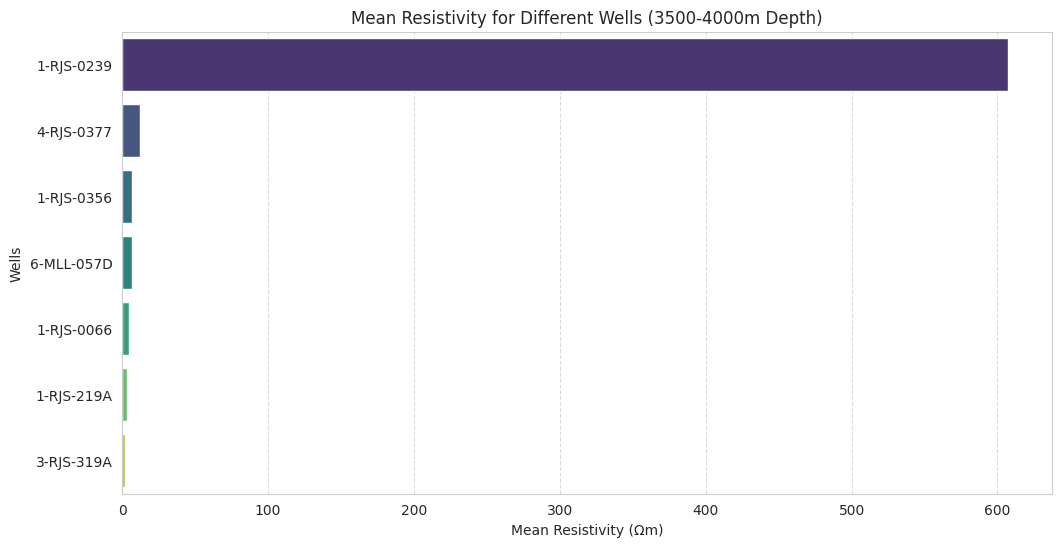

In [ ]:
depth_intervals = np.arange(0, 5000, 500)

for i in range(len(depth_intervals) - 1):
    depth_min = depth_intervals[i]
    depth_max = depth_intervals[i + 1]

    df_range = df[(df["DEPT"] >= depth_min) & (df["DEPT"] < depth_max)].copy()

    df_well_res = df_range.groupby("Well")["RESD"].mean().reset_index()
    df_well_res = df_well_res[df_well_res["RESD"] > 0]
    df_well_res = df_well_res.sort_values(by="RESD", ascending=False)

    if not df_well_res.empty:
        plt.figure(figsize=(12, 6))
        ax = sns.barplot(x="RESD", y="Well", data=df_well_res, palette="viridis")

        plt.xlabel("Mean Resistivity (Ωm)")
        plt.ylabel("Wells")
        plt.title(f"Mean Resistivity for Different Wells ({depth_min}-{depth_max}m Depth)")
        plt.grid(axis="x", linestyle="--", alpha=0.7)
        plt.show()


* The extreme values of some of the wells (0239 and 219A )suggests either a unique geological formation (such as a highly resistive lithology or a gas pocket) or sensor anomalies in these particular wells.
* If this well is part of a known high-resistivity formation, this could be a gas reservoir.
* Since all the other wells in this range have relatively low resistivity values, it raises suspicion about whether 0239 and 219A are anomalies.

For the next part of the code we are going to remove values above 500

In [ ]:
df = df[df["RESD"] < 500].copy()

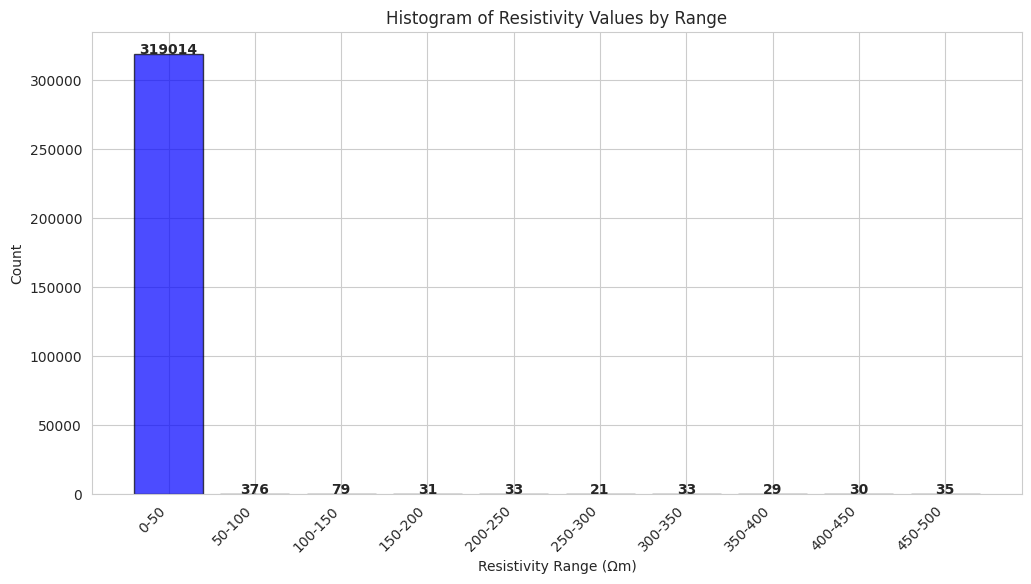

In [ ]:
bins = np.arange(0, df["RESD"].max() + 50, 50)
hist_counts, bin_edges = np.histogram(df["RESD"], bins=bins)

bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]

plt.figure(figsize=(12, 6))
plt.bar(bin_labels, hist_counts, color='blue', alpha=0.7, edgecolor='black')
plt.xticks(rotation=45, ha="right")
plt.xlabel("Resistivity Range (Ωm)")
plt.ylabel("Count")
plt.title("Histogram of Resistivity Values by Range")

for i, count in enumerate(hist_counts):
    plt.text(i, count + 100, str(count), ha='center', fontsize=10, fontweight='bold')

plt.show()

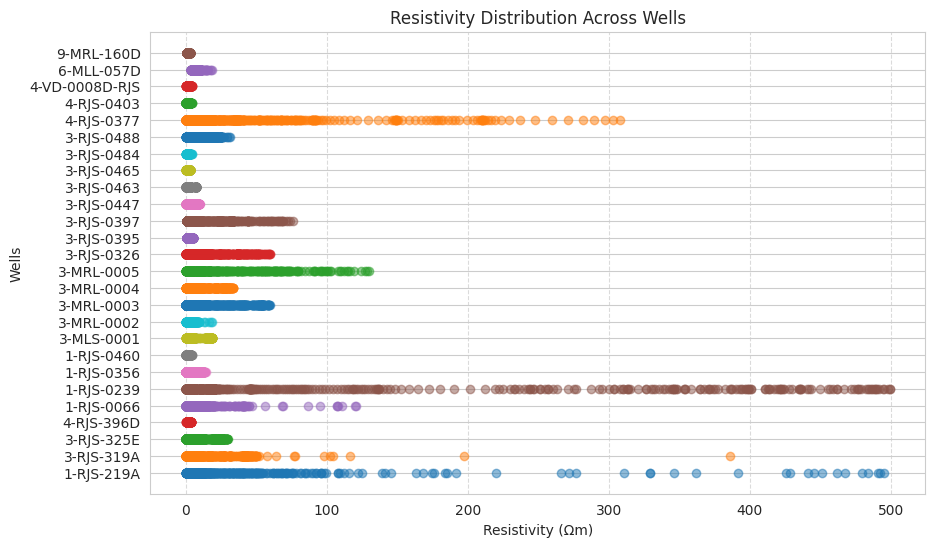

In [ ]:
plt.figure(figsize=(10, 6))

for well in df["Well"].unique():
    subset = df[df["Well"] == well]
    plt.scatter(subset["RESD"], [well] * len(subset), label=well, alpha=0.5)

plt.xlabel("Resistivity (Ωm)")
plt.ylabel("Wells")
plt.title("Resistivity Distribution Across Wells")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
unique_wells = df[df["RESD"] > 50]["Well"].unique()
unique_wells

array(['1-RJS-219A', '3-RJS-319A', '1-RJS-0066', '1-RJS-0239',
       '3-MRL-0003', '3-MRL-0005', '3-RJS-0326', '3-RJS-0397',
       '4-RJS-0377'], dtype=object)

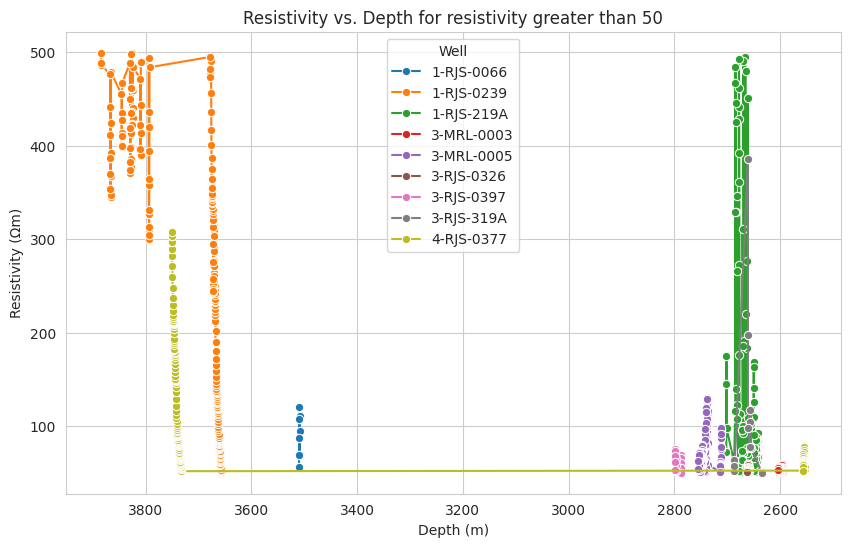

In [ ]:
df_filtered = df[(df["Well"].isin(unique_wells)) &
                 (df["RESD"] > 50)]

df_filtered = df_filtered.sort_values(["Well", "DEPT"])
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_filtered, x="DEPT", y="RESD", hue="Well", marker="o")

plt.gca().invert_xaxis()
plt.xlabel("Depth (m)")
plt.ylabel("Resistivity (Ωm)")
plt.title("Resistivity vs. Depth for resistivity greater than 50")
plt.legend(title="Well")
plt.grid(True)
plt.show()

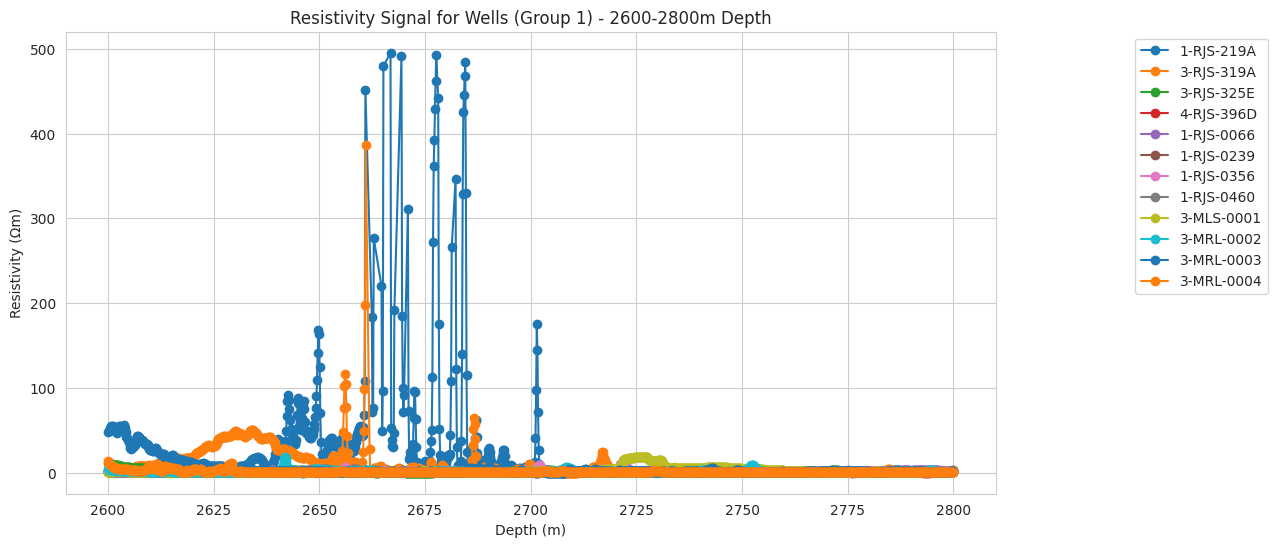

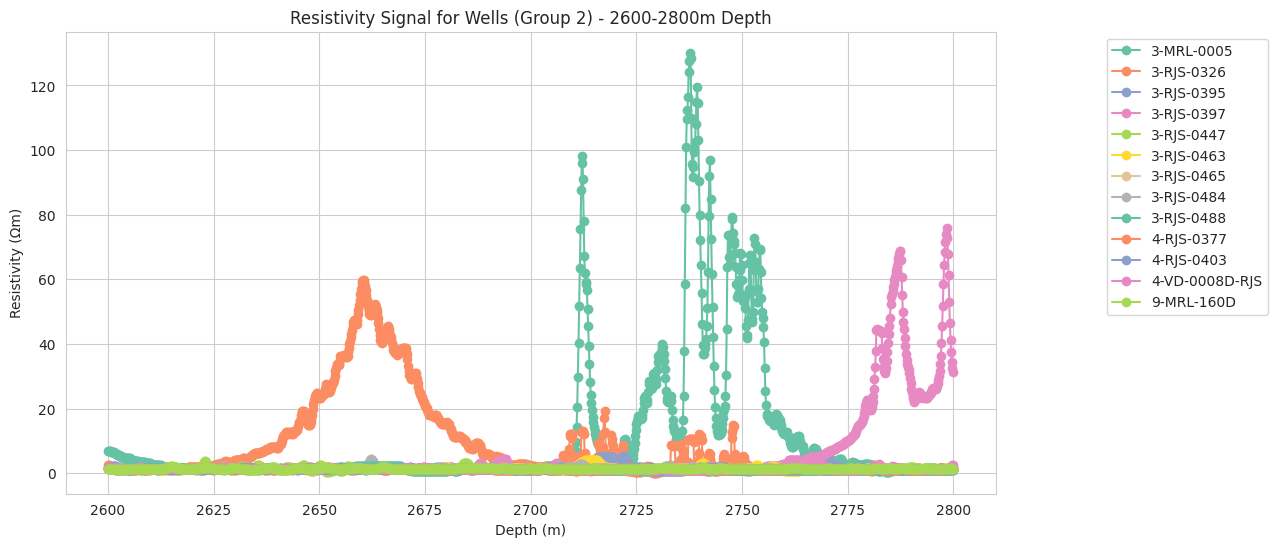

In [ ]:

df_filtered = df[(df["DEPT"] >= 2600) & (df["DEPT"] <= 2800)]

valid_wells = df_filtered["Well"].unique()
n_wells = len(valid_wells)

wells_group1 = valid_wells[: n_wells // 2]
wells_group2 = valid_wells[n_wells // 2:]

palette1 = sns.color_palette("tab10", len(wells_group1))
palette2 = sns.color_palette("Set2", len(wells_group2))

plt.figure(figsize=(12, 6))
for well, color in zip(wells_group1, palette1):
    well_data = df_filtered[df_filtered["Well"] == well]
    if not well_data.empty:
        plt.plot(well_data["DEPT"], well_data["RESD"], label=well, marker="o", linestyle="-", color=color)

plt.xlabel("Depth (m)")
plt.ylabel("Resistivity (Ωm)")
plt.title("Resistivity Signal for Wells (Group 1) - 2600-2800m Depth")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
for well, color in zip(wells_group2, palette2):
    well_data = df_filtered[df_filtered["Well"] == well]
    if not well_data.empty:
        plt.plot(well_data["DEPT"], well_data["RESD"], label=well, marker="o", linestyle="-", color=color)

plt.xlabel("Depth (m)")
plt.ylabel("Resistivity (Ωm)")
plt.title("Resistivity Signal for Wells (Group 2) - 2600-2800m Depth")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()


 ### Overview of Resistivity Signal Plots
The two graphs display resistivity variations across different wells in the 2600-2800m depth range. The wells were split into two groups to improve clarity and address color repetition.

* This plot shows wells with significantly fluctuating resistivity values, such as 1-RJS-219A and 3-RJS-319A, which have large spikes around 2650-2700m.
Other wells, show relatively stable and low resistivity across the depth range.
The peaks in 1-RJS-219A exceed 500 Ωm, which stands out significantly from the general trend.
* The high-frequency fluctuations in resistivity, particularly in wells such as 1-RJS-219A, 3-RJS-319A, and 3-MRL-0005, appear erratic, which might suggest potential sensor malfunctions or miscalibration.

* If the spikes were purely due to sensor faults, we would expect them to occur randomly across all wells. However, 2-4 wells exhibit similar resistivity spikes in the same depth range, suggesting a possible subsurface geological phenomenon.

* These spikes could be indicative of hydrocarbon deposits or changes in formation composition, such as the presence of a fault zone, lithological boundary, or fluid variation.

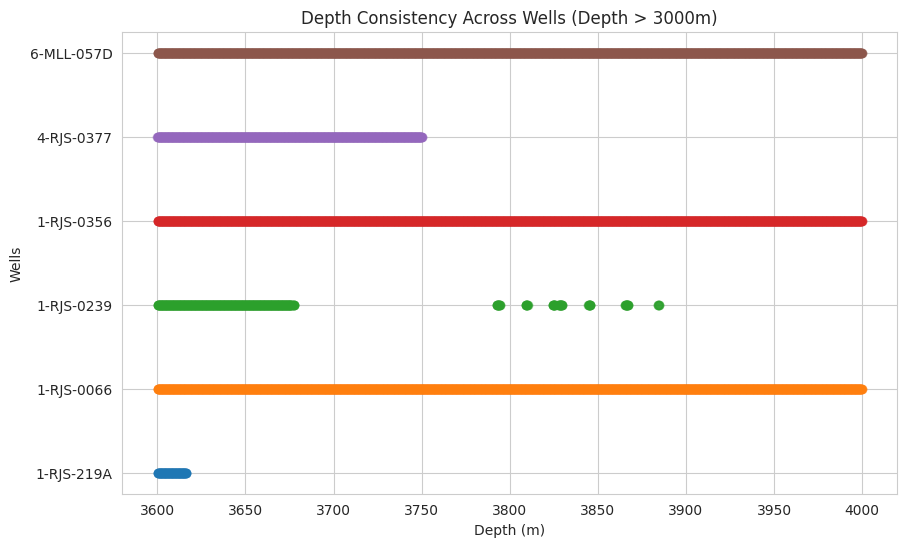

In [ ]:
df_filtered = df[df["DEPT"] > 3600]
plt.figure(figsize=(10, 6))
for well in df_filtered["Well"].unique():
    subset = df_filtered[df_filtered["Well"] == well]
    plt.scatter(subset["DEPT"], [well] * len(subset), label=well, alpha=0.5)

plt.xlabel("Depth (m)")
plt.ylabel("Wells")
plt.title("Depth Consistency Across Wells (Depth > 3000m)")
plt.show()


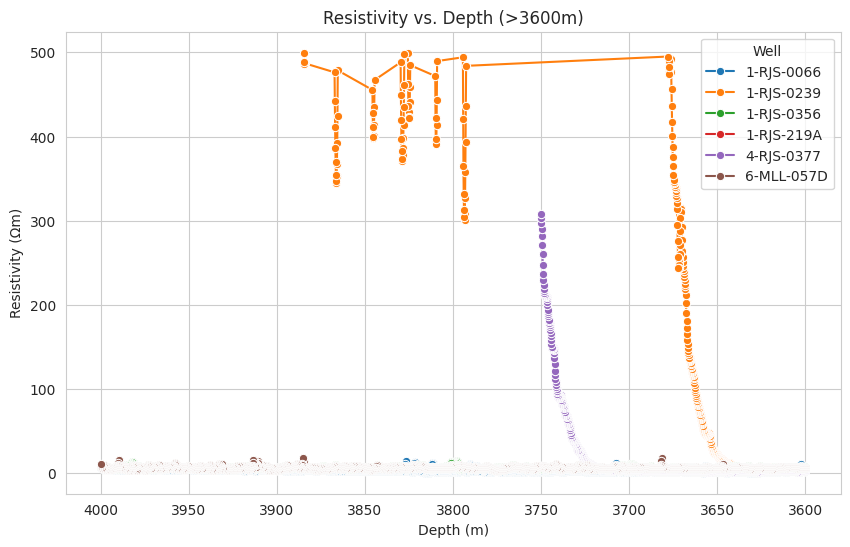

In [ ]:
df_filtered = df_filtered.sort_values(["Well", "DEPT"])
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_filtered, x="DEPT", y="RESD", hue="Well", marker="o")

plt.gca().invert_xaxis()
plt.xlabel("Depth (m)")
plt.ylabel("Resistivity (Ωm)")
plt.title("Resistivity vs. Depth (>3600m)")
plt.legend(title="Well")
plt.grid(True)
plt.show()


Analysis of Resistivity vs. Depth (>3600m)
Key Observations:
Well 1-RJS-0239 (Orange) Exhibits a Significant Spike:

This well shows consistently high resistivity values (close to 500 Ωm) at depths between 3600m and 3800m.
The values remain high and fluctuate slightly but maintain an overall elevated trend.
Compared to other wells, this pattern appears anomalous, as no other well shows such consistently high readings in this range.
Possible Causes of the Anomaly:

Instrumental Error: The sustained high resistivity might be due to sensor miscalibration or faulty data logging.
Geological Factor: If this well is located in a distinct formation, it may contain hydrocarbons or tight rock formations with minimal conductivity, leading to increased resistivity.
Well-Specific Conditions: There could be local lithological variations affecting resistivity, such as gas pockets or highly compacted formations.

Comparative Analysis with Other Wells:

4-RJS-0377 (Purple) Shows a Resistivity Spike at ~3750m: This suggests some shared geological feature between this and 1-RJS-0239.
Other Wells (Brown, Blue, Green) Exhibit Low Resistivity Values: Their resistivity is close to zero, indicating the presence of more conductive materials, possibly water-bearing formations.

The high resistivity values in 1-RJS-0239 seem to be either an instrumental anomaly or indicative of a distinct geological formation. The presence of another resistivity spike in 4-RJS-0377 suggests that this may not be a random error but rather a localized geological characteristic. However, further cross-validation with other geophysical logs is necessary to confirm the cause.

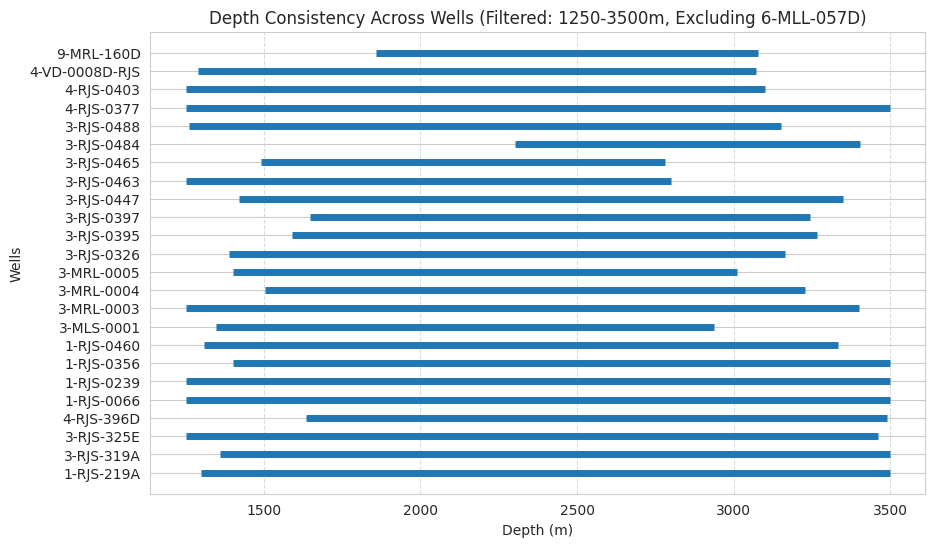

In [ ]:
df_filtered = df[(df["Well"] != "6-MLL-057D") & (df["Well"] != "3-MRL-0002") & (df["Well"] != "3-MRL-0484")& (df["DEPT"] >= 1250) & (df["DEPT"] <= 3500)]

plt.figure(figsize=(10, 6))

for well in df_filtered["Well"].unique():
    well_data = df_filtered[df_filtered["Well"] == well]
    plt.hlines(y=well, xmin=well_data["DEPT"].min(), xmax=well_data["DEPT"].max(), linewidth=5, label=well)

plt.xlabel("Depth (m)")
plt.ylabel("Wells")
plt.title("Depth Consistency Across Wells (Filtered: 1250-3500m, Excluding 6-MLL-057D)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


In [ ]:
df = df[df["RESD"] < 50].copy()

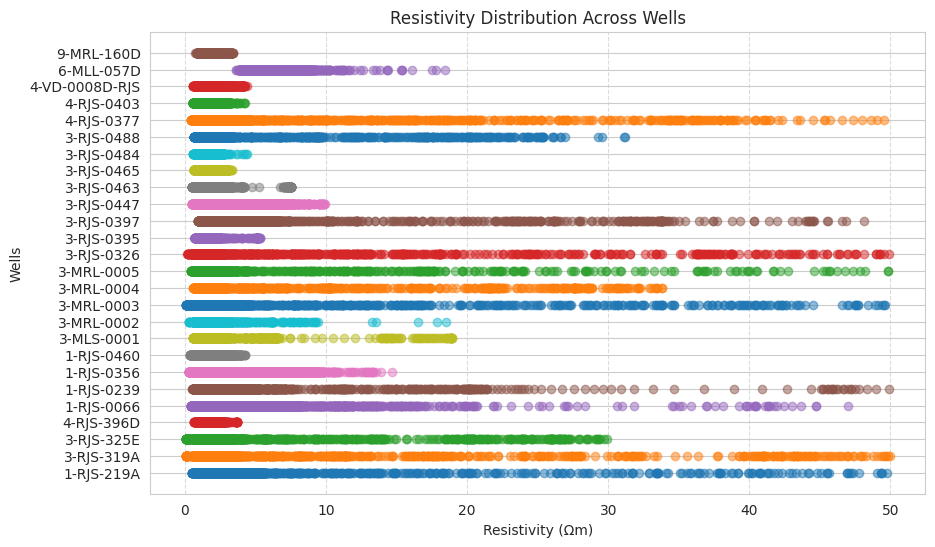

In [ ]:
plt.figure(figsize=(10, 6))

for well in df["Well"].unique():
    subset = df[df["Well"] == well]
    plt.scatter(subset["RESD"], [well] * len(subset), label=well, alpha=0.5)

plt.xlabel("Resistivity (Ωm)")
plt.ylabel("Wells")
plt.title("Resistivity Distribution Across Wells")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

# Models

**Now that we have analyzed all resistivity values above 50 Ωm, we need to examine the 0-50 Ωm range, as most of the data falls within this category. To identify patterns and potential anomalies, we can apply K-Nearest Neighbors (KNN) clustering to analyze trends and classify resistivity distributions across different wells.**

1. Formation Classification (Unsupervised Learning)

* Goal:
 Use clustering algorithms (e.g., K-Means, DBSCAN) to classify different formation layers based on resistivity values.

* Why is this useful?

 * Different formations have unique resistivity signatures (e.g., sandstones, shales, and carbonates).

 * Helps automatically detect formation boundaries, reducing manual geological interpretation.

* ML Techniques:
 - K-Means Clustering: Groups depth-resistivity pairs into clusters.
 - DBSCAN: Detects abrupt formation changes.

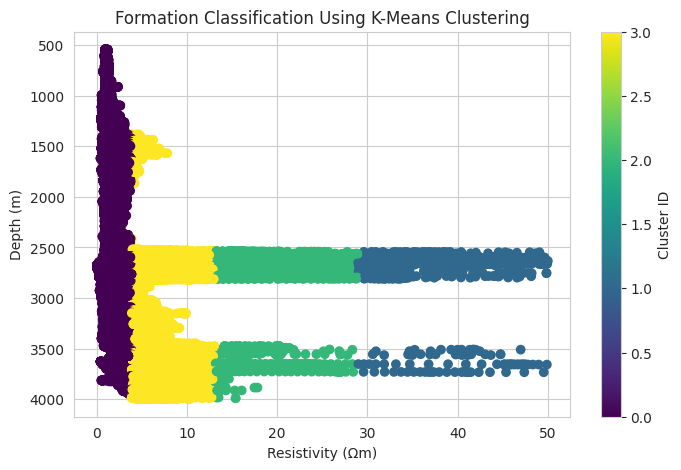

In [ ]:
from sklearn.cluster import KMeans

# Normalization - (min-max)
df["RESD_norm"] = (df["RESD"] - df["RESD"].min()) / (df["RESD"].max() - df["RESD"].min())

# K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
df["Cluster"] = kmeans.fit_predict(df[["RESD_norm"]])

plt.figure(figsize=(8, 5))
plt.scatter(df["RESD"], df["DEPT"], c=df["Cluster"], cmap="viridis")
plt.gca().invert_yaxis()
plt.xlabel("Resistivity (Ωm)")
plt.ylabel("Depth (m)")
plt.title("Formation Classification Using K-Means Clustering")
plt.colorbar(label="Cluster ID")
plt.show()


* The different colors (clusters) suggest that the subsurface consists of at least 4 different formation types.
* Low resistivity values (darker colors) likely indicate shale or water-filled formations.

How to identify gas?
* Gas formations have higher resistivity than water-filled formations

* Gas is non-conductive, unlike water, which contains dissolved ions and has lower resistivity.
* Hydrocarbon-bearing formations (oil/gas) resist electric current, leading to higher resistivity values.
* Cluster with highest resistivity values is the likely gas zone
* If the high-resistivity cluster is consistent across multiple wells, it strengthens the likelihood that it represents a hydrocarbon-bearing formation rather than an anomaly.

In [ ]:
df.groupby("Cluster")["RESD"].mean().sort_values()

,RESD
Cluster,
0,1.469648
3,6.301100
2,19.801893
1,38.120625


In [ ]:
df.groupby("Cluster")["DEPT"].mean().sort_values()

,DEPT
Cluster,
0,2271.137779
1,2770.687652
2,2797.684308
3,3380.332070


In [ ]:
high_resistivity_cluster = df.groupby("Cluster")["RESD"].mean().idxmax()
print(f"Cluster with highest resistivity: {high_resistivity_cluster}")

Cluster with highest resistivity: 1


In [ ]:
high_res_df = df[df["Cluster"] == high_resistivity_cluster]

high_res_df.groupby("Well")["DEPT"].describe()


,count,mean,std,min,25%,50%,75%,max
Well,,,,,,,,
1-RJS-0066,32.0,3538.806291,22.148535,3508.2168,3511.074225,3555.68945,3556.870600,3563.9951
1-RJS-0239,33.0,3655.122397,1.473637,3652.6841,3653.903100,3655.12230,3656.341600,3657.5608
1-RJS-219A,79.0,2655.680670,12.975163,2639.8774,2647.268800,2653.44090,2659.003500,2701.1421
3-MRL-0003,100.0,2597.488855,8.268167,2586.2280,2590.000000,2593.77195,2606.078100,2611.3740
3-MRL-0004,32.0,2580.877984,3.534783,2577.1729,2578.353950,2580.22080,2582.087675,2590.2793
3-MRL-0005,48.0,2737.398858,12.413555,2711.1638,2730.328125,2738.44345,2747.511200,2755.3599
3-RJS-0326,106.0,2663.779375,6.236017,2653.4824,2657.482900,2665.14100,2669.141550,2673.1421
3-RJS-0397,93.0,2796.289209,9.799370,2781.3328,2784.837900,2799.77290,2803.278300,2809.9839
3-RJS-0488,4.0,2585.851550,0.196696,2585.6230,2585.737300,2585.85155,2585.965800,2586.0801


<ipython-input-45-40eff24d61a1>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned = df.groupby(["Well", "Depth_Bin"])["RESD"].mean().reset_index()


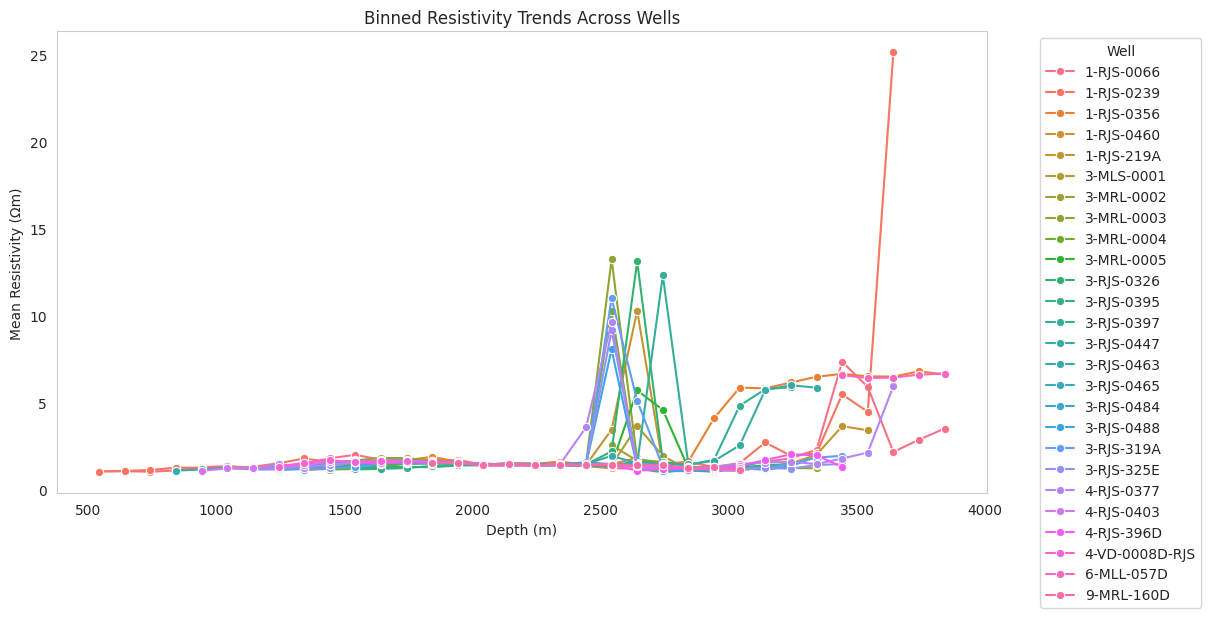

In [ ]:
bin_size = 100
depth_bins = np.arange(df["DEPT"].min(), df["DEPT"].max(), bin_size)

df["Depth_Bin"] = pd.cut(df["DEPT"], bins=depth_bins, labels=depth_bins[:-1], include_lowest=True)

# Compute mean resistivity per bin for each well
df_binned = df.groupby(["Well", "Depth_Bin"])["RESD"].mean().reset_index()

# Visualizing the resistivity trends in depth bins
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_binned, x="Depth_Bin", y="RESD", hue="Well", marker="o")

plt.xlabel("Depth (m)")
plt.ylabel("Mean Resistivity (Ωm)")
plt.title("Binned Resistivity Trends Across Wells")
plt.legend(title="Well", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.show()


<ipython-input-47-3cd15201c815>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned = df.groupby(["Well", "Depth_Bin"])["RESD"].median().reset_index()


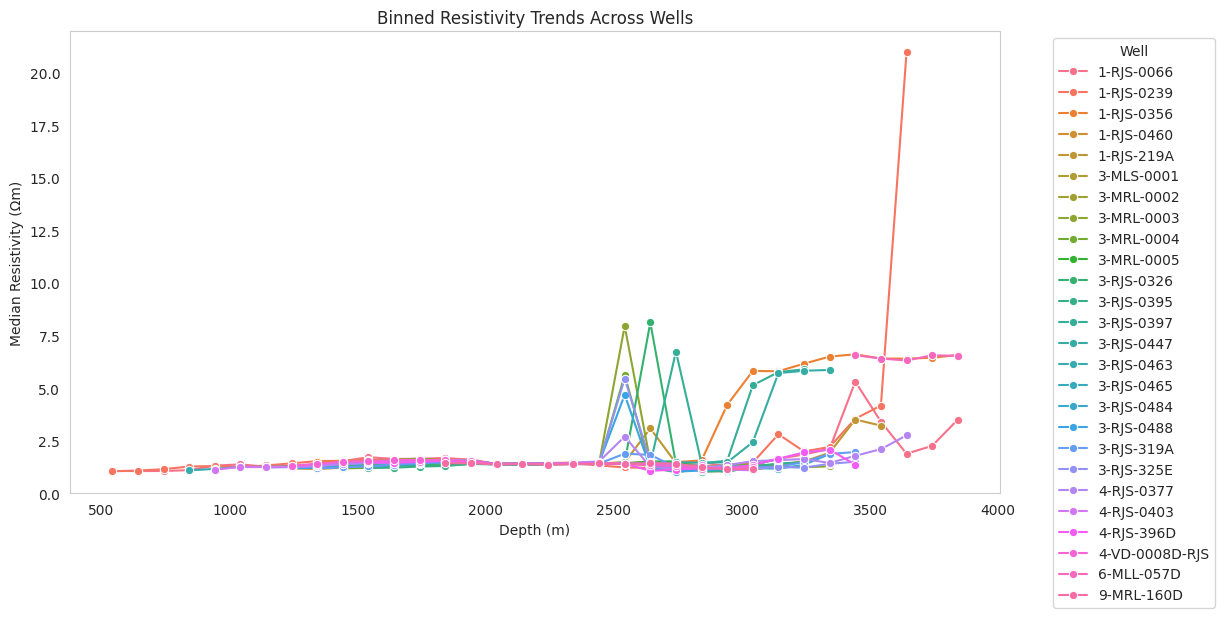

In [ ]:
bin_size = 100
depth_bins = np.arange(df["DEPT"].min(), df["DEPT"].max(), bin_size)

df["Depth_Bin"] = pd.cut(df["DEPT"], bins=depth_bins, labels=depth_bins[:-1], include_lowest=True)

# Compute mean resistivity per bin for each well
df_binned = df.groupby(["Well", "Depth_Bin"])["RESD"].median().reset_index()

# Visualizing the resistivity trends in depth bins
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_binned, x="Depth_Bin", y="RESD", hue="Well", marker="o")

plt.xlabel("Depth (m)")
plt.ylabel("Median Resistivity (Ωm)")
plt.title("Binned Resistivity Trends Across Wells")
plt.legend(title="Well", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.show()